In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import seaborn as sns
pd.set_option('display.max_columns', None)
import sys
sys.path.append('..')
sys.path.append('../..')
sys.path.append('.')
sys.path.append('./scripts')
from competing_methods_local import *
from simulations_util import *
from util import apply_splitting_strategy
from sklearn.preprocessing import StandardScaler

/accounts/projects/binyu/zhongyuan_liang/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 2.0

### Classification

In [3]:
task = "classification" 
combined_df = pd.DataFrame()
datasets = ['openml_361063', 'openml_361069', 'openml_361062', 'openml_9978', 'openml_361071', 'openml_43']
split_seeds = [1,2,3,4]
sample_seeds = [1,2,3,4,5]
for data in datasets:
    ablation_directory =f"/accounts/projects/binyu/zhongyuan_liang/local_MDI+/imodels-experiments/feature_importance/results/mdi_local.real_data_{task}_{data}/{data}_selection/varying_sample_row_n"
    for split_seed in split_seeds:
        for sample_seed in sample_seeds:
            df = pd.read_csv(os.path.join(ablation_directory, f"seed_{split_seed}_{sample_seed}/results.csv"))
            df["data"] = data
            combined_df = pd.concat([combined_df, df], ignore_index=True)

In [4]:
methods = [
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus',    
    'MDI',
    # 'MDI+',
    'LIME_RF',
    'TreeSHAP_RF'
]
color_map = {
    'LIME_RF': '#71BEB7',
    'TreeSHAP_RF': 'orange',
    'MDI': '#9B5DFF',
    'MDI+': 'red',
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus': 'black',
    'Ablation_model1': '#FF6F61',
    'Ablation_model2': '#6F61FF',
}

data_name = {
    "openml_43": "Spam",
    "openml_361062": "Pol",
    "openml_361071": "Jannis",
    "openml_9978": "Ozone",
    "openml_361069": "Higgs",
    "openml_361063": "House 16H"
}

feature_values = {
    "openml_43": 57,
    "openml_361062": 26,
    "openml_361071": 54,
    "openml_9978": 47,
    "openml_361069": 24,
    "openml_361063": 16
}

methods_name = {
    'LIME_RF': 'LIME',
    'MDI': 'bLoTLA',
    'MDI+': 'MDI+',
    'TreeSHAP_RF': 'TreeSHAP',
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus': 'LoTLA',
    'Ablation_model1': 'LoTLA+',
    'Ablation_model2': 'LoTLA++',
}

<>:65: DeprecationWarning: invalid escape sequence '\ '
<>:65: DeprecationWarning: invalid escape sequence '\ '
/tmp/ipykernel_2618332/351988808.py:65: DeprecationWarning: invalid escape sequence '\ '
  ax.set_title(f"$\\mathbf{{{dataset_label} \ (p={p_val}) }}$", fontsize=25)
/scratch/users/zhongyuan_liang/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/scratch/users/zhongyuan_liang/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/scratch/users/zhongyuan_liang/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib

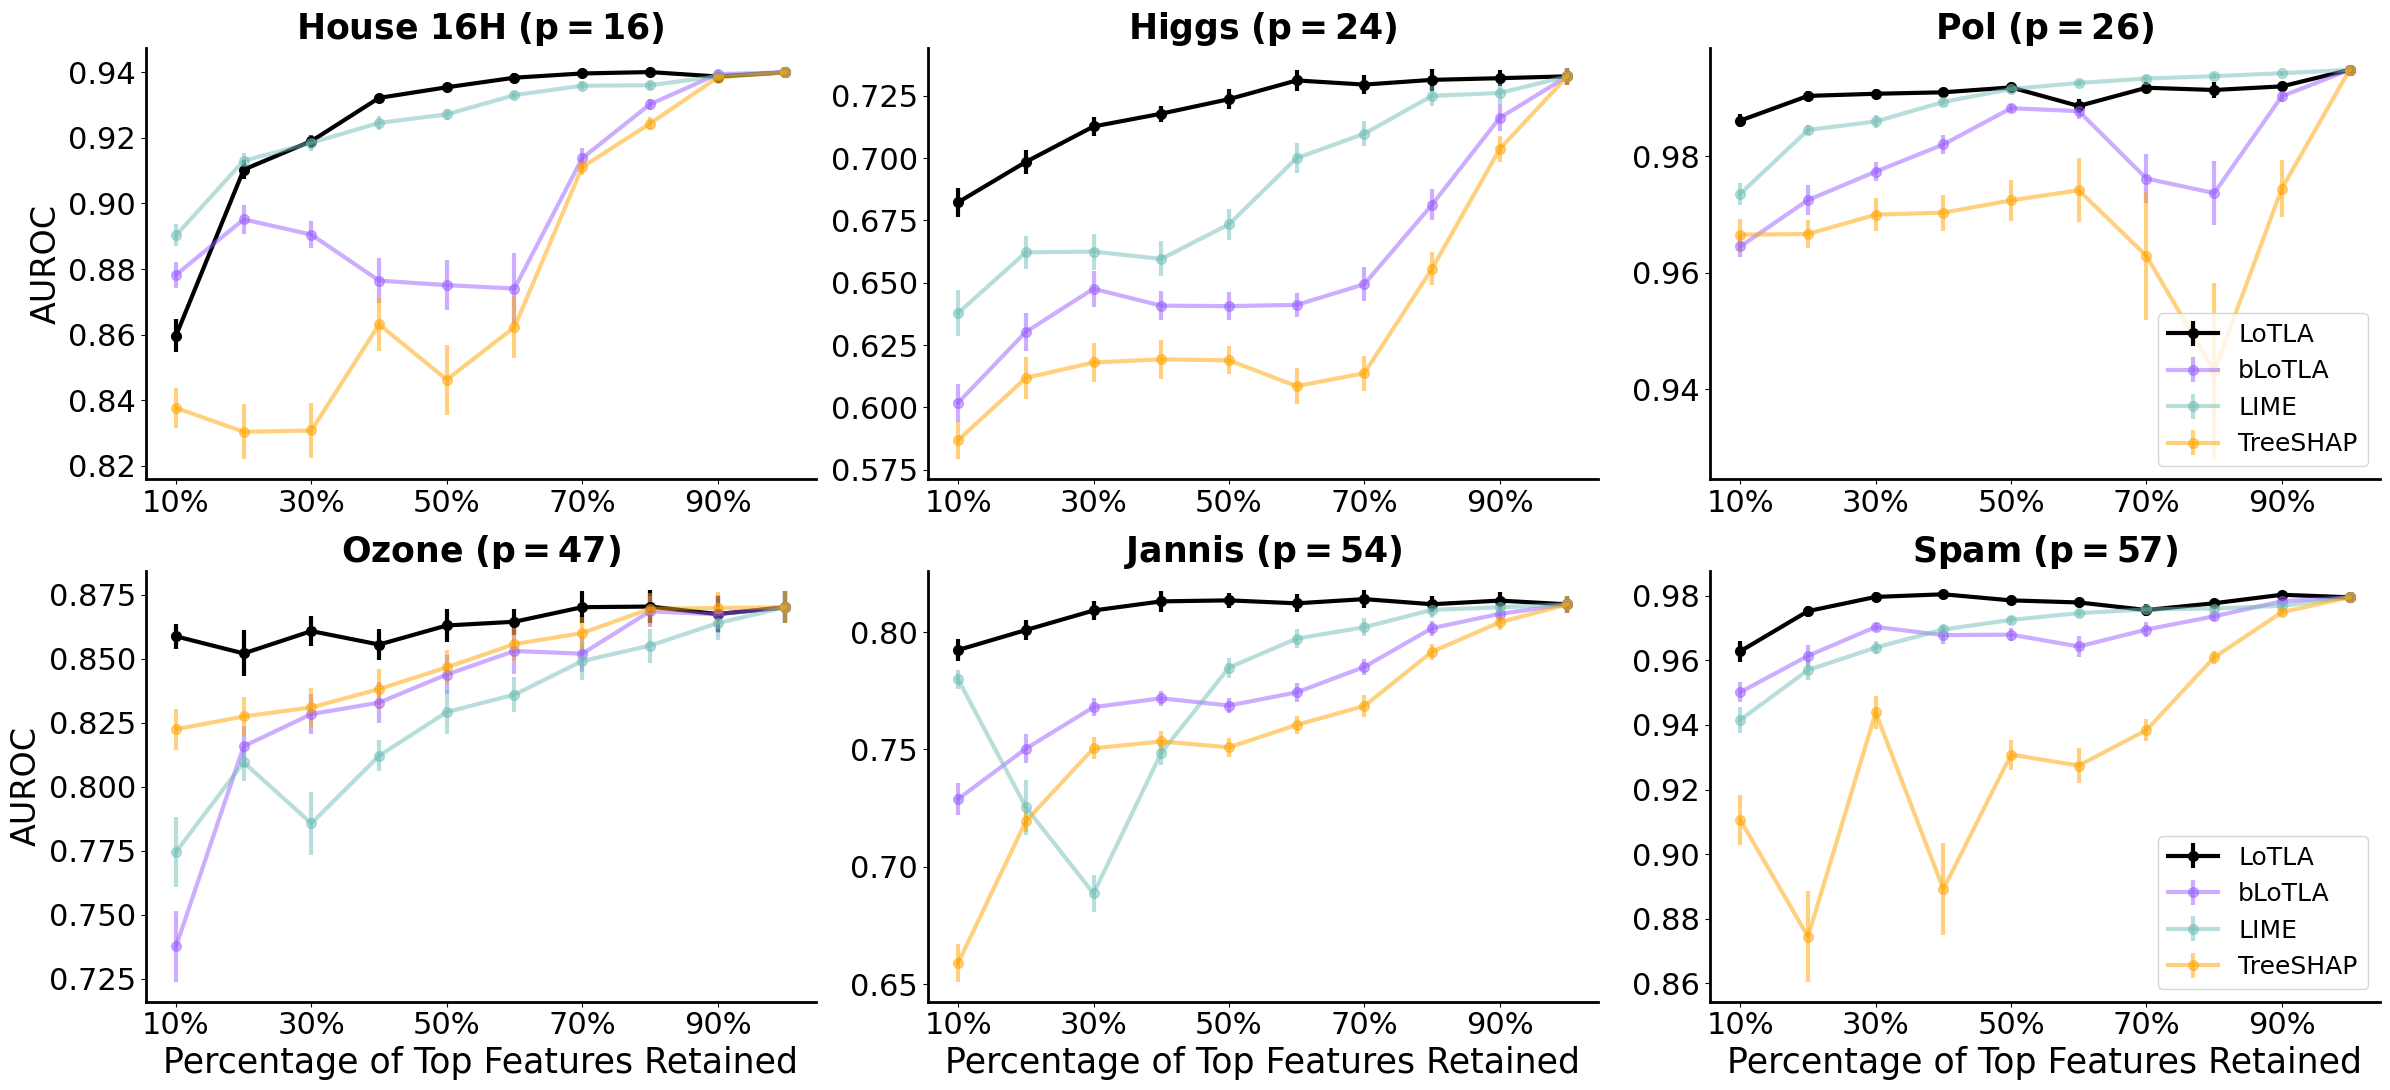

In [5]:
df = combined_df#[combined_df["sample_row_n"] == 2000]  
datasets = df["data"].unique()

marker_size = 7
dotted_methods = ['LIME_RF', 'TreeSHAP_RF', 'MDI']

n_cols = 3
n_rows = 2

fig, axs = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(8 * n_cols, 5.5 * n_rows),
    sharey=False
)

axs = axs.flatten()

for idx, dataset in enumerate(datasets):
    ax = axs[idx]
    subset = df[df["data"] == dataset]

    for method in methods:
        method_data = subset[subset["fi"] == method]

        auroc_cols = [
            "RF_Classifier_AUROC_keep_0.1", "RF_Classifier_AUROC_keep_0.2", "RF_Classifier_AUROC_keep_0.3",
            "RF_Classifier_AUROC_keep_0.4", "RF_Classifier_AUROC_keep_0.5", "RF_Classifier_AUROC_keep_0.6",
            "RF_Classifier_AUROC_keep_0.7", "RF_Classifier_AUROC_keep_0.8", "RF_Classifier_AUROC_keep_0.9",
            "RF_Classifier_AUROC_keep_1.0"
        ]
        means = method_data[auroc_cols].mean(axis=0).values
        stds = method_data[auroc_cols].std(axis=0).values
        counts = method_data[auroc_cols].count(axis=0).values
        sems = stds / np.sqrt(counts)

        x = [0.1, 0.2, 0.3, 0.4,0.5,0.6,0.7,0.8,0.9,1.0]

        if method in ['LIME_RF', 'TreeSHAP_RF', 'MDI', 'MDI+']:
            ax.errorbar(
                x, means, sems,
                label=methods_name[method], linestyle='solid',
                marker='o', markersize=marker_size, color=color_map[method], linewidth=3, alpha=0.5
            )
        else:
            ax.errorbar(
                x, means, sems,
                label=methods_name[method], linestyle='solid',
                marker='o', markersize=marker_size, color=color_map[method], linewidth=3
            )

    ax.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9])
    ax.set_xticklabels(["10%", "30%", "50%", "70%", "90%"], fontsize=22)
    ax.tick_params(axis='y', labelsize=22)
    if idx >= (n_rows - 1) * n_cols:
        ax.set_xlabel("Percentage of Top Features Retained", fontsize=25)

    if idx % n_cols == 0:
        ax.set_ylabel("AUROC", fontsize=24)
    else:
        ax.set_ylabel("")
    
    dataset_label = data_name[dataset].replace(' ', r'\ ')
    p_val = feature_values[dataset]
    ax.set_title(f"$\\mathbf{{{dataset_label} \ (p={p_val}) }}$", fontsize=25)
    
    if (idx + 1) % n_cols == 0 or idx == len(datasets) - 1:
        ax.legend(fontsize=18, loc='lower right')

plt.tight_layout()
plt.savefig("feature_selection_classification_full.png")
plt.show()

In [6]:
df_summary = df.groupby(['fi', 'data'])[["RF_Classifier_AUROC_keep_0.1", "RF_Classifier_AUROC_keep_0.2", "RF_Classifier_AUROC_keep_0.3", "RF_Classifier_AUROC_keep_0.4"]].mean().reset_index()
df_summary = df_summary[(df_summary["fi"] != "MDI+") & (df_summary["fi"] != "Ablation_model1") & (df_summary["fi"] != "Ablation_model2") & (df_summary["fi"] != "Ablation_model0")]
columns_to_rank = ["RF_Classifier_AUROC_keep_0.1", "RF_Classifier_AUROC_keep_0.2", "RF_Classifier_AUROC_keep_0.3", "RF_Classifier_AUROC_keep_0.4"]
rank_results_classification = pd.DataFrame()
for data in datasets:
    df_data = df_summary[df_summary["data"] == data]
    ranked_df = df_data.copy()
    for col in columns_to_rank:
        ranked_df[col] = df_data[col].rank(ascending=False, method='min')
    rank_results_classification = pd.concat([rank_results_classification, ranked_df], ignore_index=True)
rank_results_classification.columns = ['fi', 'data', 'top_0.1', 'top_0.2', 'top_0.3', 'top_0.4']
rank_results_classification.groupby('fi')[['top_0.1', 'top_0.2', 'top_0.3', 'top_0.4']].mean().sort_values(by='top_0.1')

,top_0.1,top_0.2,top_0.3,top_0.4
fi,,,,
Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus,1.333333,1.166667,1.000000,1.000000
LIME_RF,2.166667,2.500000,2.833333,2.666667
MDI,3.000000,2.666667,2.666667,2.833333
TreeSHAP_RF,3.500000,3.666667,3.500000,3.500000


### Regression

In [7]:
task = "regression" 
combined_df = pd.DataFrame()
datasets = ['openml_361260', 'openml_361254', 'openml_361259', 'openml_361253', 'openml_361243', 'openml_361242']
split_seeds = [1,2,3,4]
sample_seeds = [1,2,3,4,5]
for data in datasets:
    ablation_directory =f"/accounts/projects/binyu/zhongyuan_liang/local_MDI+/imodels-experiments/feature_importance/results/mdi_local.real_data_{task}_{data}/{data}_selection/varying_sample_row_n"
    for split_seed in split_seeds:
        for sample_seed in sample_seeds:
            df = pd.read_csv(os.path.join(ablation_directory, f"seed_{split_seed}_{sample_seed}/results.csv"))
            df["data"] = data
            combined_df = pd.concat([combined_df, df], ignore_index=True)

In [8]:
methods = [
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus',    
    'MDI',
    # 'MDI+',
    'LIME_RF',
    'TreeSHAP_RF'
]
color_map = {
    'LIME_RF': '#71BEB7',
    'TreeSHAP_RF': 'orange',
    'MDI': '#9B5DFF',
    'MDI+': 'red',
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus': 'black',
    'Ablation_model1': '#FF6F61',
    'Ablation_model2': '#6F61FF',
}

data_name = {
    "openml_361260": "Miami Housing",
    "openml_361259": "Puma Robot",
    "openml_361253": "Wave Energy",
    "openml_361254": "SARCOS",
    "openml_361242": "Super Conductivity",
    "openml_361243": "Geographic Origin of Music"
}

feature_values = {
    "openml_361260": 15,
    "openml_361259": 32,
    "openml_361253": 48,
    "openml_361254": 21,
    "openml_361242": 81,
    "openml_361243": 72
}

methods_name = {
    'LIME_RF': 'LIME',
    'MDI': 'bLoTLA',
    'MDI+': 'MDI+',
    'TreeSHAP_RF': 'TreeSHAP',
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus': 'LoTLA',
    'Ablation_model1': 'Ablation1',
    'Ablation_model2': 'Ablation2',
}

<>:59: DeprecationWarning: invalid escape sequence '\ '
<>:59: DeprecationWarning: invalid escape sequence '\ '
/tmp/ipykernel_2618332/633486681.py:59: DeprecationWarning: invalid escape sequence '\ '
  ax.set_title(f"$\\mathbf{{{dataset_label} \ (p={p_val}) }}$", fontsize=25)


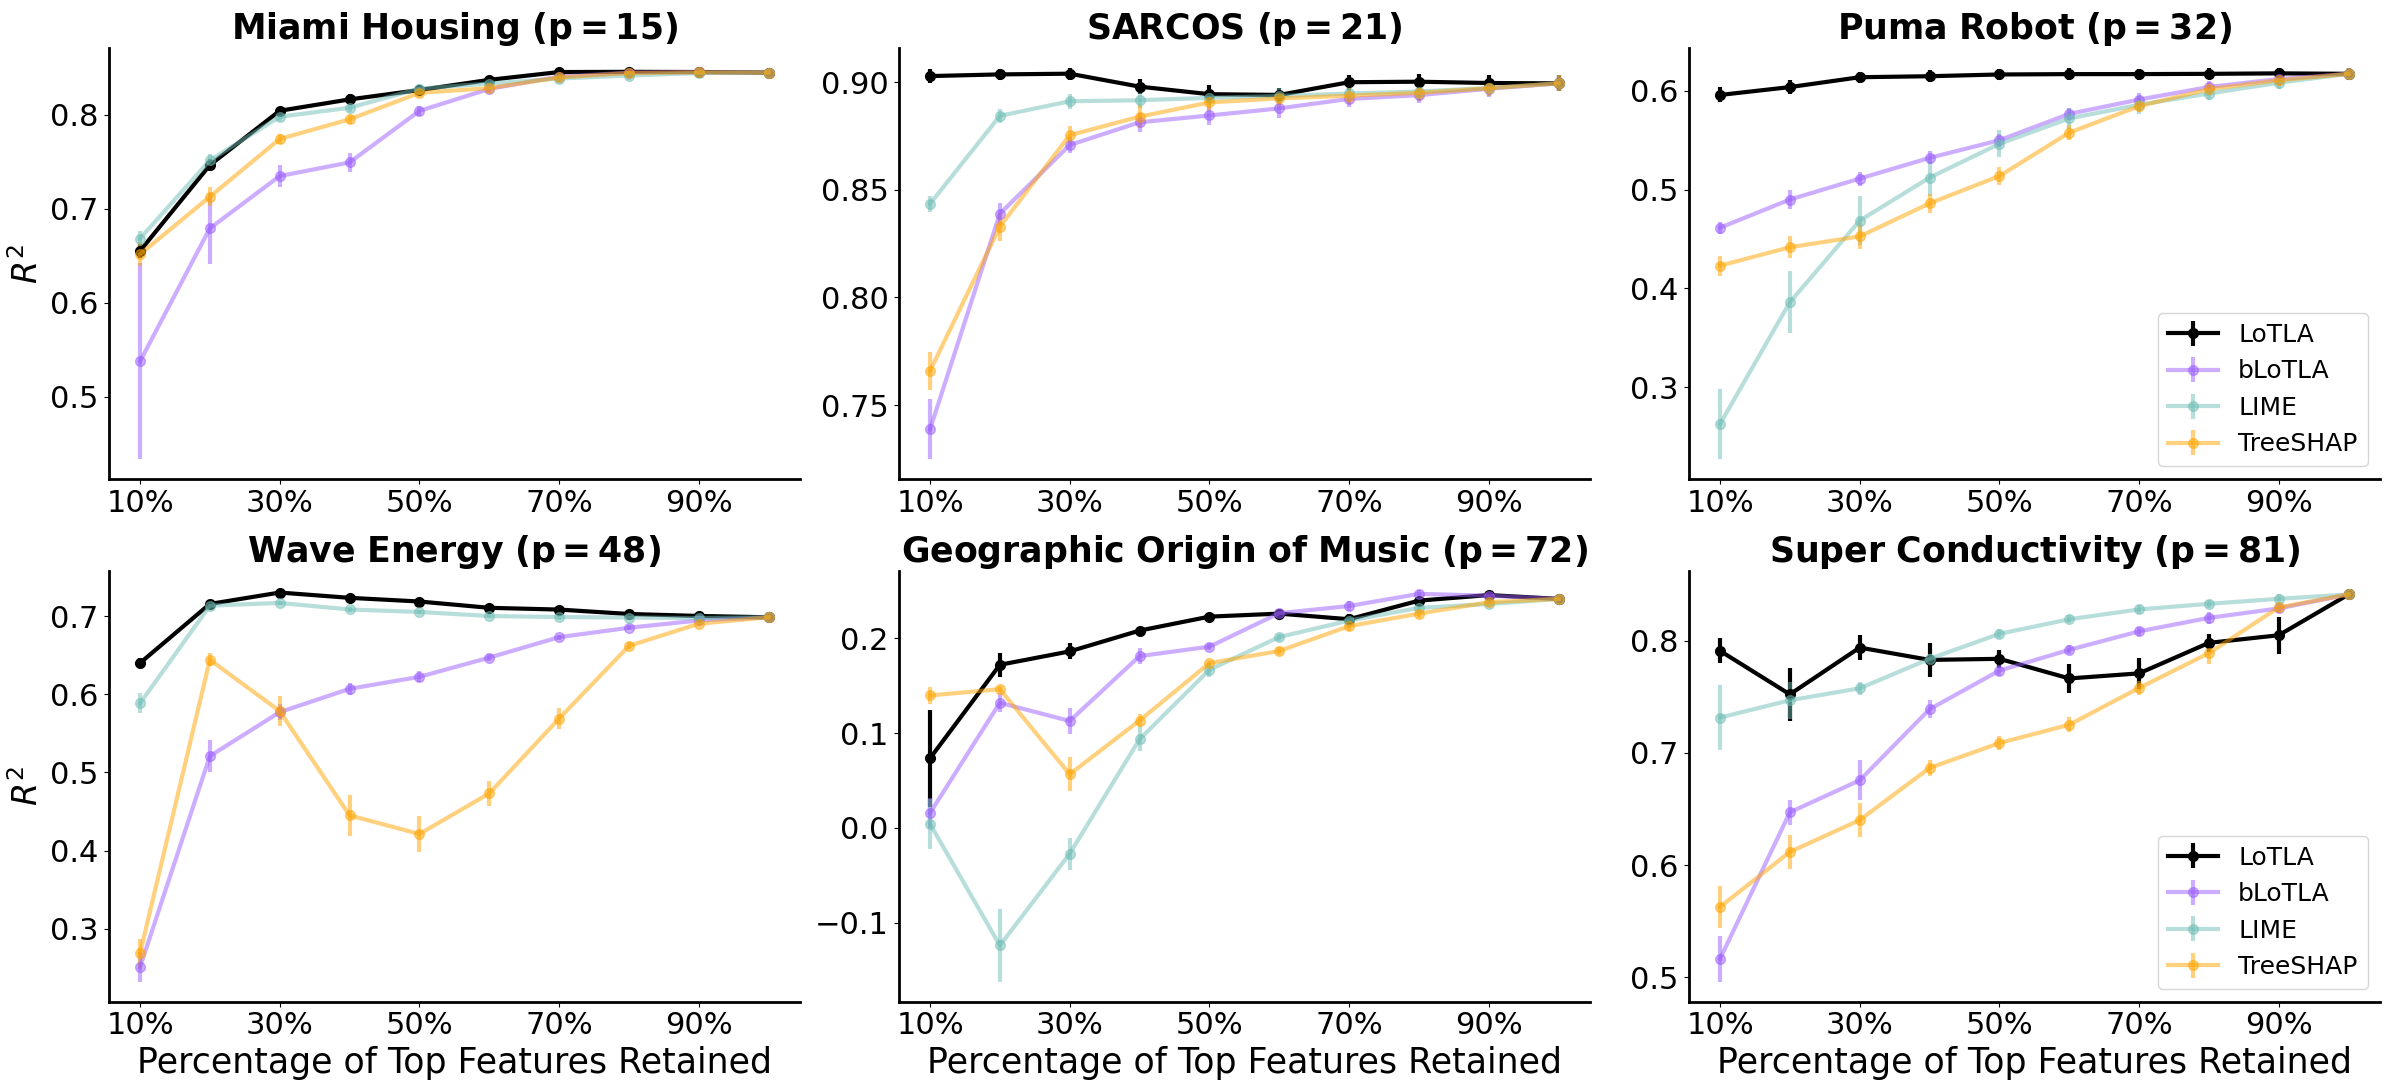

In [9]:
df = combined_df#[combined_df["sample_row_n"] == 2000]  
datasets = df["data"].unique()

marker_size = 7

n_cols = 3
n_rows = 2

fig, axs = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(8 * n_cols, 5.5 * n_rows),
    sharey=False
)

axs = axs.flatten()

for idx, dataset in enumerate(datasets):
    ax = axs[idx]
    subset = df[df["data"] == dataset]
    
    for method in methods:
        method_data = subset[subset["fi"] == method]
        r2_col = ["RF_Regressor_R2_keep_0.1", "RF_Regressor_R2_keep_0.2", "RF_Regressor_R2_keep_0.3",
            "RF_Regressor_R2_keep_0.4", "RF_Regressor_R2_keep_0.5", "RF_Regressor_R2_keep_0.6", "RF_Regressor_R2_keep_0.7",
            "RF_Regressor_R2_keep_0.8", "RF_Regressor_R2_keep_0.9", "RF_Regressor_R2_keep_1.0"]
        means = method_data[r2_col].mean(axis=0).values
        stds = method_data[r2_col].std(axis=0).values
        counts = method_data[r2_col].count(axis=0).values
        sems = stds / np.sqrt(counts)
        x = [0.1, 0.2, 0.3, 0.4,0.5,0.6,0.7,0.8,0.9,1.0]

        if method in ['LIME_RF', 'TreeSHAP_RF', 'MDI', 'MDI+']:
            ax.errorbar(
                x, means, sems,
                label=methods_name[method], linestyle='solid',
                marker='o', markersize=marker_size, color=color_map[method], linewidth=3, alpha=0.5
            )
        else:
            ax.errorbar(
                x, means, sems,
                label=methods_name[method], linestyle='solid',
                marker='o', markersize=marker_size, color=color_map[method], linewidth=3
            )

    ax.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9])
    ax.set_xticklabels(["10%", "30%", "50%", "70%", "90%"], fontsize=22)
    ax.tick_params(axis='y', labelsize=22)
    if idx >= (n_rows - 1) * n_cols:
        ax.set_xlabel("Percentage of Top Features Retained", fontsize=25)
    
    if idx % n_cols == 0:
        ax.set_ylabel(r"$R^2$", fontsize=24)
    else:
        ax.set_ylabel("")
    
    dataset_label = data_name[dataset].replace(' ', r'\ ')
    p_val = feature_values[dataset]
    ax.set_title(f"$\\mathbf{{{dataset_label} \ (p={p_val}) }}$", fontsize=25)
    
    if (idx + 1) % n_cols == 0 or idx == len(datasets) - 1:
        ax.legend(fontsize=18, loc='lower right')

plt.tight_layout()
plt.savefig("feature_selection_regression_full.png")
plt.show()

In [10]:
df_summary = df.groupby(['fi', 'data'])[["RF_Regressor_R2_keep_0.1", "RF_Regressor_R2_keep_0.2", "RF_Regressor_R2_keep_0.3", "RF_Regressor_R2_keep_0.4"]].mean().reset_index()
df_summary = df_summary[(df_summary["fi"] != "MDI+") & (df_summary["fi"] != "Ablation_model1") & (df_summary["fi"] != "Ablation_model2") & (df_summary["fi"] != "Ablation_model0")]
columns_to_rank = ["RF_Regressor_R2_keep_0.1", "RF_Regressor_R2_keep_0.2", "RF_Regressor_R2_keep_0.3", "RF_Regressor_R2_keep_0.4"]
rank_results_regression = pd.DataFrame()
for data in datasets:
    df_data = df_summary[df_summary["data"] == data]
    ranked_df = df_data.copy()
    for col in columns_to_rank:
        ranked_df[col] = df_data[col].rank(ascending=False, method='min')
    rank_results_regression = pd.concat([rank_results_regression, ranked_df], ignore_index=True)
rank_results_regression.columns = ['fi', 'data', 'top_0.1', 'top_0.2', 'top_0.3', 'top_0.4']
rank_results_regression.groupby('fi')[['top_0.1', 'top_0.2', 'top_0.3', 'top_0.4']].mean().sort_values(by='top_0.1')

,top_0.1,top_0.2,top_0.3,top_0.4
fi,,,,
Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus,1.333333,1.166667,1.000000,1.166667
LIME_RF,2.500000,2.500000,2.500000,2.333333
TreeSHAP_RF,2.666667,3.166667,3.333333,3.500000
MDI,3.500000,3.166667,3.166667,3.000000


In [12]:
pd.concat([rank_results_classification, rank_results_regression], ignore_index=True).groupby('fi')[['top_0.1', 'top_0.2', 'top_0.3', 'top_0.4']].mean().sort_values(by='top_0.1')

,top_0.1,top_0.2,top_0.3,top_0.4
fi,,,,
Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus,1.333333,1.166667,1.000000,1.083333
LIME_RF,2.333333,2.500000,2.666667,2.500000
TreeSHAP_RF,3.083333,3.416667,3.416667,3.500000
MDI,3.250000,2.916667,2.916667,2.916667
